<strong> Import all libraires that will be used </strong>

In [1]:
from utils import PaintingsDataset, Generator, Unet_Discriminator, Unet_Generator, unet_d_criterion_without_cutmix, AttentionUNetGenerator, AttentionUNetDiscriminator
import random
import torch
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
import torch.optim as optim
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import os

<strong> Initializing the paintings dataset </strong>

In [2]:
# Building the dataset
image_dir = '../../data/anime/images_2'
image_size = 64
f = os.listdir(image_dir)[0]
print(f)
print(os.path.isfile(os.path.join(image_dir, f)))

# Transformations to normalize the data before dataloader
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)), # Standardizing the size of the images
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])


# Initializing the dataset
training_dataset = PaintingsDataset(image_dir, transform, limit=10000)
print(f"Dataset contains {len(training_dataset)} images")

44838_2014.jpg
True
Dataset contains 10000 images


<strong> Sampling an element from the dataset and plotting it </strong>

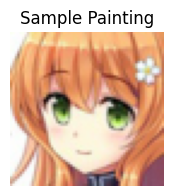

In [3]:
# Sampling randomly an element from the dataset
n = len(training_dataset)
integer = random.randint(0,n)

# Sampled image
image = training_dataset[integer].numpy()*0.5 + 0.5 # De-normalizing the image

# Plot the image
plt.figure(figsize=(3, 2))
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting')
plt.show()

<strong> Intializing the Dataloader </strong>

In [4]:
batch_size = 64
dataloader = DataLoader(training_dataset, batch_size=batch_size)

<strong> Initializing the parameters of the model </strong>

In [5]:
# Model's parameters
latent_dim = 100
channels_out = 3
channels_in = 3

# Intializing the models
G = Generator(latent_dim, channels_out)
D = Unet_Discriminator(3, 2)

<strong> Sampling a vector to plot the fake image generated by the Generator </strong>

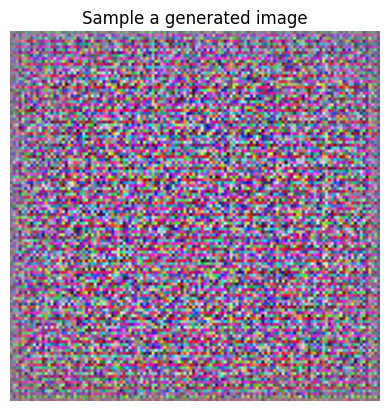

In [6]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G(noise)

# De-normalizing the image
image_generated = fake_images.detach().numpy().reshape((3,128,128))*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image_generated, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample a generated image')
plt.show()

<strong> Let build the training loop</strong>

In [7]:
torch.autograd.set_detect_anomaly(True)


loss_options = ["w","bce"]
loss_option = loss_options[1]

experiment = 4

output_dir = f"training_samples/experiment_{experiment}"
os.makedirs(output_dir, exist_ok=True)


# Parameters
batch_size = 64
input_channels = 3
n_classes = 2
k = 5  # number of discriminator updates per generator update
epochs =  1000
latent_dim = 128  # Dimension of the latent space
lambda_gp = 10  # Gradient penalty weight
lambda_div = 5  # Diversity loss weight


d_lr = 1e-4 if loss_option == "w" else 2e-4  # Base learning rate
g_lr = 2e-4 if loss_option == "w" else 2e-4  # Base learning rate


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Initialize models
G_unet = Unet_Generator(latent_dim, channels_out).to(device)  
D_unet = Unet_Discriminator(input_channels, n_classes=n_classes).to(device)
# G_unet = AttentionUNetGenerator(latent_dim, channels_out).to(device)
# D_unet = AttentionUNetDiscriminator(input_channels).to(device)

# Loss function and optimizers
criterion = unet_d_criterion_without_cutmix
# criterion = torch.nn.BCELoss()
optimizer_g = torch.optim.Adam(G_unet.parameters(), lr=g_lr, betas=(0.0, 0.9) if loss_option == "w" else (0.5, 0.999))
optimizer_d = torch.optim.Adam(D_unet.parameters(), lr=d_lr, betas=(0.0, 0.9) if loss_option == "w" else (0.5, 0.999))

# FID Evaluation setup
epoch_fid = epochs // 20  # Evaluate FID every `epoch_eval` epochs
epoch_sampling = 10 # Save generated samples every `epoch_sampling` epochs

fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500


# Ensure your dataset of real paintings is available
N = len(training_dataset)  # Assuming `paintings` is a tensor of real images
indices = random.sample(range(N), n_samples)
real_images_eval = torch.stack([training_dataset[idx] for idx in indices])
fid.update(real_images_eval, real=True)


# Track losses and FID values
FID_values = []
D_loss = []
G_loss = []


for epoch in tqdm(range(1, epochs+1)):
    start_time = time.time()

    # Turn dataloader into an iterator for this epoch
    data_iter = iter(dataloader)
    ################################################################
    # 1) DISCRIMINATOR UPDATES — do k iterations
    ################################################################  
    while True:
        for _ in range(k):
            try:
                # Get next batch of real images
                real_images = next(data_iter).to(device)
            except StopIteration:
                # If we've exhausted the dataloader, end this epoch
                break
            
            # Labels for real and fake images
            batch_size = real_images.size(0)

            labels_real = torch.full((batch_size, 1), 0.9, device=device)
            labels_fake = torch.full((batch_size, 1), 0.1, device=device)

            # Train discriminator with real images
            optimizer_d.zero_grad()

            # Optionally add small noise to real images
            real_noisy = real_images + torch.randn_like(real_images) * 0.01

            output_real = D_unet(real_noisy)
            loss_d_real = criterion(output_real, labels_real, batch_size=batch_size)

            # Train discriminator with fake images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = G_unet(noise).detach() # detach so G is not updated here

            fake_noisy = fake_images + torch.randn_like(fake_images) * 0.01

            output_fake = D_unet(fake_noisy)
            loss_d_fake = criterion(output_fake, labels_fake, batch_size=batch_size)

            loss_d = loss_d_real + loss_d_fake
            loss_d.backward()
            optimizer_d.step()

        else:
            ################################################################
            # 2) GENERATOR UPDATE — 1 iteration
            ################################################################
            for p in D_unet.parameters():
                p.requires_grad = False
            
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = G_unet(noise)

            optimizer_g.zero_grad()

            output_fake_gen = D_unet(fake_images)

            labels_real = torch.full((batch_size, 1), 0.9, device=device)
            loss_g = criterion(output_fake_gen, labels_real, batch_size=batch_size)  # Labels for generator are real

            loss_g.backward()
            optimizer_g.step()

            for p in D_unet.parameters():
                p.requires_grad = True
         # Go back to the while loop for next set of k updates + 1 gen update
            continue

        # If we did break out of the for-loop (StopIteration),
        # it means we've run out of data for this epoch.
        break
    
    
     # Evaluate FID every `epoch_eval` epochs
    if epoch % epoch_fid == 0:
        G_unet.eval()  # Set generator to eval mode for FID computation
        fake_images_eval = []
        with torch.no_grad():
        # Generate evaluation images
            noise_eval = torch.randn(n_samples, latent_dim, 1, 1, device=device)
            for i in range(0, n_samples, batch_size):
                fake_images_chunk = G_unet(noise_eval[i:i+batch_size]).to('cpu')
                fid.update(fake_images_chunk, real=False)
                fake_images_eval.append(fake_images_chunk)

            fid_value = fid.compute().item()
            FID_values.append(fid_value)

            print(f'FID after epoch {epoch}: {fid_value}')

        # Save a grid of generated samples
        fake_images_eval = torch.cat(fake_images_eval, dim=0)
        grid = vutils.make_grid(fake_images_eval[:64], normalize=True, scale_each=True)
        sample_path = os.path.join(output_dir, f"epoch_{epoch:03d}.png")
        vutils.save_image(grid, sample_path)
        print(f"Sample images saved to {sample_path}")
        
        del fake_images_eval
        torch.cuda.empty_cache()
        fid.reset()
        G_unet.train()
        
    elif epoch % epoch_sampling == 0:
        G_unet.eval()  # Set generator to eval mode for FID computation
        
        # Generate evaluation images
        with torch.no_grad():
            noise_eval = torch.randn(64, latent_dim, 1, 1, device=device)
            fake_images_eval = G_unet(noise_eval).to(torch.device('cpu'))
        
        # Save a grid of generated samples
        grid = vutils.make_grid(fake_images_eval, normalize=True, scale_each=True)
        sample_path = os.path.join(output_dir, f"step_{epoch:03d}.png")
        vutils.save_image(grid, sample_path)
        print(f"Sample images saved to {sample_path}")
        
        del fake_images_eval
        torch.cuda.empty_cache()
        G_unet.train()
        
        # Track losses
        D_loss.append(loss_d.item())
        G_loss.append(loss_g.item())


    end_time = time.time()
    
    print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    print(f'Epoch duration: {end_time - start_time:.2f}s')
    

cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000]
Epoch [1/1000] | Loss D: 4827.033203125 | Loss G: 8629.7099609375
Epoch duration: 71.67s
Epoch [2/1000]
Epoch [2/1000] | Loss D: 5654.4677734375 | Loss G: 2072.23876953125
Epoch duration: 68.92s
Epoch [3/1000]
Epoch [3/1000] | Loss D: 40300.49609375 | Loss G: 10423.8671875
Epoch duration: 69.77s
Epoch [4/1000]
Epoch [4/1000] | Loss D: 5660.24560546875 | Loss G: 2525.365234375
Epoch duration: 69.65s
Epoch [5/1000]
Epoch [5/1000] | Loss D: 2999.810791015625 | Loss G: 8088.10009765625
Epoch duration: 66.05s
Epoch [6/1000]
Epoch [6/1000] | Loss D: 5720.8662109375 | Loss G: 5475.59375
Epoch duration: 66.55s
Epoch [7/1000]
Epoch [7/1000] | Loss D: 5634.904296875 | Loss G: 3219.88916015625
Epoch duration: 69.80s
Epoch [8/1000]
Epoch [8/1000] | Loss D: 5615.609375 | Loss G: 3063.023193359375
Epoch duration: 69.88s
Epoch [9/1000]
Epoch [9/1000] | Loss D: 2994.974609375 | Loss G: 8483.4716796875
Epoch duration: 68.80s
Epoch [10/1000]
Sample images saved to training_samples/experim

KeyboardInterrupt: 

In [28]:
torch.save(D_unet.state_dict(), "models/d_unet.pth")
torch.save(G_unet.state_dict(), "models/g_unet.pth")

<strong> Generating some examples using the trained generator </strong>

torch.Size([1, 3, 128, 128])


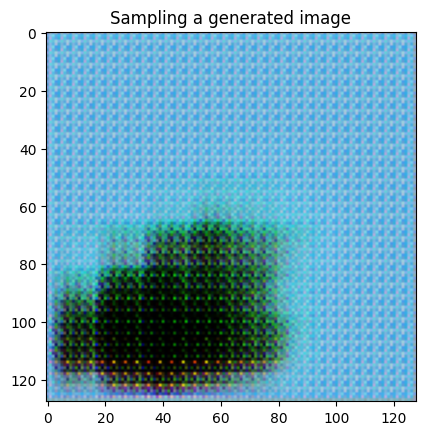

In [32]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

G_unet_test = G_unet.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

print(fake_images.size())  # Should be (16, img_channels, height, width)

image_noise = fake_images.detach().numpy().reshape((3,64,64))*0.5 + 0.5

plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

<strong> Plotting Losses <strong>

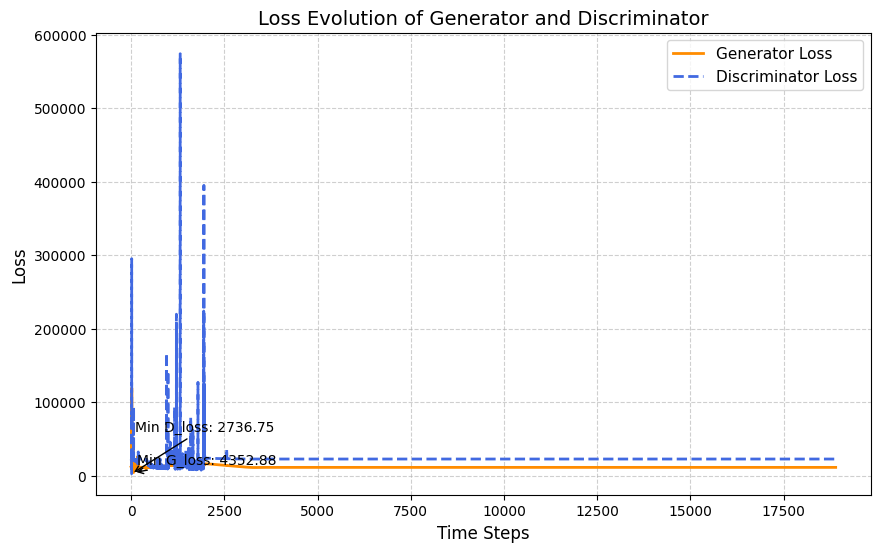

In [30]:
# Assuming G_loss and D_loss are defined
ng = len(G_loss)
nd = len(D_loss)
time_steps_g = [i for i in range(ng)]
time_steps_d = [i for i in range(nd)]


plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps_g, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps_d, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()

<strong> Plotting FID values <strong>

Text(0.5, 1.0, 'FID Evolution through training')

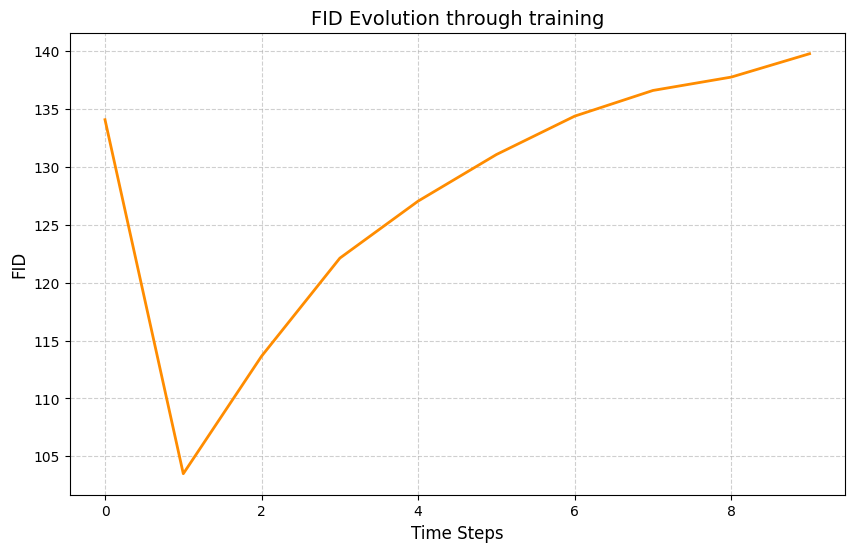

In [31]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)